# Semantic Similarities: Differences in distance among different sub-reddits
#### Benchmark is the askscience subreddit. An analysis in how far other subreddits (askmen, askwoman, democracts & republicans) deviate from this benchmark is conducted


In [261]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
import os
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
import glob

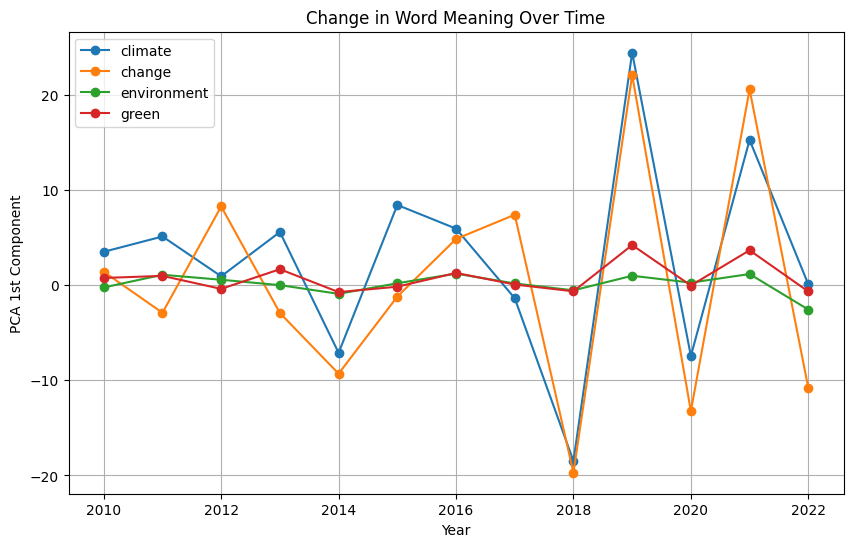

In [262]:
# Step 1: Load the embeddings
years = list(range(2010, 2023))
embeddings = {}
for year in years:
    embeddings[year] = pd.read_csv(f'/Users/fabianmahner/dlss-project24/output/embeddings/yearly_embeddings/embeddings_CBOW_posts_{year}.csv')

# Step 2: Align the words (ensure all embeddings have the same words)
words = set(embeddings[years[0]]['word'])
for year in years[1:]:
    words &= set(embeddings[year]['word'])

words = list(words)  # list of common words across all years

# Step 3: Concatenate the embeddings for each word across all years
all_embeddings = []

for year in years:
    df = embeddings[year]
    df = df[df['word'].isin(words)]
    all_embeddings.append(df.set_index('word').loc[words].values)

all_embeddings = np.stack(all_embeddings, axis=0)  # Shape: (num_years, num_words, embedding_dim)

# Step 4: Normalize the data
# Reshape to (num_years * num_words, embedding_dim) for normalization
all_embeddings_reshaped = all_embeddings.reshape(len(years) * len(words), -1)

# Apply StandardScaler
scaler = StandardScaler()
all_embeddings_normalized = scaler.fit_transform(all_embeddings_reshaped)

# Step 5: Apply PCA to reduce to 1 dimension
pca = PCA(n_components=1)
pca_result = pca.fit_transform(all_embeddings_normalized)

# Reshape back to (num_years, num_words) after PCA
pca_result = pca_result.reshape(len(years), len(words))

# Step 6: Visualize the change over time for selected words
selected_words = ['climate', 'change', 'environment', 'green']

plt.figure(figsize=(10, 6))

for word in selected_words:
    index = words.index(word)
    y = pca_result[:, index]  
    plt.plot(years, y, marker='o', label=word)
    # Optional: You can use plt.text to label the points if needed
    #plt.text(years[-1], y[-1], word, fontsize=12)

plt.xlabel('Year')
plt.ylabel('PCA 1st Component')
plt.title('Change in Word Meaning Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [263]:
path = '/Users/fabianmahner/dlss-project24/output/embeddings/not_ask_science_embeddings/'  
csv_files = glob.glob(path + "*.csv")

dfs = []
# Iterate through each CSV file and read it into a DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    # Assuming the first column is 'word' and the rest are embeddings
    # You can adjust the range [1:] based on your actual column structure
    embedding_columns = df.columns[1:]  
    dfs.append(df)

# Concatenate all DataFrames into one, stacking them vertically
combined_df = pd.concat(dfs, ignore_index=True)

# Group by 'word' and calculate the mean for each dimension, ignoring NaN values
# Only apply mean calculation to the embedding columns
embedding_columns = combined_df.columns[1:]
average_embeddings_df = combined_df.groupby('word')[embedding_columns].mean().reset_index()

# Drop all rows that contain any NaN values
average_embeddings_df = average_embeddings_df.dropna()

# Save the resulting DataFrame to a new CSV file
average_embeddings_df.to_csv('/Users/fabianmahner/dlss-project24/output/embeddings/subreddit_embeddings/embeddings_CBOW_posts_NOT_askscience.csv', index=False)

/var/folders/27/3fz42pcs07s3xvry5dtl0_9r0000gn/T/ipykernel_70148/4088130876.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_embeddings_df = combined_df.groupby('word')[embedding_columns].mean().reset_index()


In [264]:
# compare cosine similarity between subreddits

# Function to find the most similar words to a given word
def find_similar_words(word, word_embeddings, top_n=10):
    """
    Find similar words to a given word based on word embeddings.

    Parameters:
    - word (str): The word to find similar words for.
    - word_embeddings (pandas.DataFrame): The word embeddings matrix.
    - top_n (int): The number of similar words to return (default: 10).

    Returns:
    - similar_words (numpy.ndarray): An array of similar words.
    - similarities (numpy.ndarray): An array of similarity scores corresponding to the similar words.
    """
    word_vector = word_embeddings.loc[word].values.reshape(1, -1)
    similarities = cosine_similarity(word_vector, word_embeddings)
    similarities = similarities.flatten()
    most_similar_indices = np.argsort(similarities)[::-1][1:top_n+1]
    similar_words = word_embeddings.index[most_similar_indices]
    return similar_words, similarities[most_similar_indices]

# Filter word embeddings to include only the relevant words
climate_terms = [ "carbon", "climate", "warming"]

subreddit_files = [
    "/Users/fabianmahner/dlss-project24/output/embeddings/subreddit_embeddings/embeddings_CBOW_posts_askscience.csv",
    "/Users/fabianmahner/dlss-project24/output/embeddings/subreddit_embeddings/embeddings_CBOW_posts_democrats.csv",
    "/Users/fabianmahner/dlss-project24/output/embeddings/subreddit_embeddings/embeddings_CBOW_posts_republicans.csv",
    "/Users/fabianmahner/dlss-project24/output/embeddings/subreddit_embeddings/embeddings_CBOW_posts_NOT_askscience.csv"
]

# Dictionary to hold results for each subreddit
results_dict = {}

for subreddit_file in subreddit_files:
    # Extract subreddit name from the file path
    subreddit_name = subreddit_file.split('/')[-1].replace('embeddings_CBOW_posts_', '').replace('.csv', '')

    # Load embeddings for the current subreddit
    df_embeddings = pd.read_csv(subreddit_file)
    df_embeddings.set_index('word', inplace=True)
    
    similar_words_dict = {}
    for term in climate_terms:
        if term in df_embeddings.index:
            similar_words, similarities = find_similar_words(term, df_embeddings, top_n=3)
            similar_words_dict[term] = list(zip(similar_words, similarities))
        else:
            similar_words_dict[term] = [("N/A", 0.0)] * 3  # Handle terms not in the embeddings
    
    results_dict[subreddit_name] = similar_words_dict

# Create a DataFrame to hold the results
all_results = []
for subreddit, similar_words_dict in results_dict.items():
    for term, similar_words in similar_words_dict.items():
        for word, similarity in similar_words:
            all_results.append([subreddit, term, word, f"{similarity:.2f}"])

# Convert results to DataFrame
df_results = pd.DataFrame(all_results, columns=['Subreddit', 'Term', 'Similar Word', 'Similarity'])

# Display the table using tabulate for better formatting
print(tabulate(df_results, headers='keys', tablefmt='pipe'))
#non ask science


|    | Subreddit      | Term    | Similar Word   |   Similarity |
|---:|:---------------|:--------|:---------------|-------------:|
|  0 | askscience     | carbon  | water          |         1    |
|  1 | askscience     | carbon  | heat           |         1    |
|  2 | askscience     | carbon  | fossil         |         1    |
|  3 | askscience     | climate | it             |         0.76 |
|  4 | askscience     | climate | temperature    |         0.76 |
|  5 | askscience     | climate | scientific     |         0.75 |
|  6 | askscience     | warming | cooling        |         1    |
|  7 | askscience     | warming | deforestation  |         1    |
|  8 | askscience     | warming | ecological     |         1    |
|  9 | democrats      | carbon  | cut            |         1    |
| 10 | democrats      | carbon  | aggressive     |         1    |
| 11 | democrats      | carbon  | school         |         1    |
| 12 | democrats      | climate | its            |         0.54 |
| 13 | dem

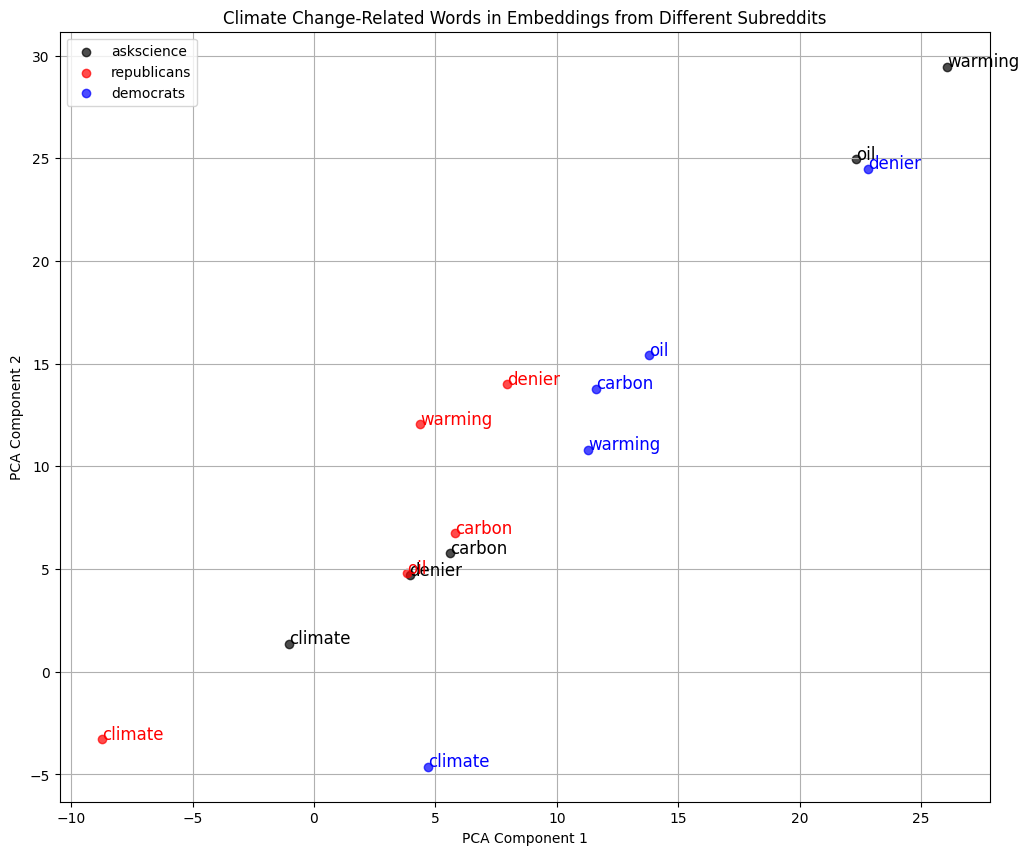

In [303]:

# Step 1: Load the embeddings from all three CSV files
files = ['/Users/fabianmahner/dlss-project24/output/embeddings/subreddit_embeddings/embeddings_CBOW_posts_askscience.csv', 
         '/Users/fabianmahner/dlss-project24/output/embeddings/subreddit_embeddings/embeddings_CBOW_posts_republicans.csv', 
         '/Users/fabianmahner/dlss-project24/output/embeddings/subreddit_embeddings/embeddings_CBOW_posts_democrats.csv'
         ]

embeddings = []


labels = ['askscience', 'republicans', 'democrats'] 
for file in files:
    df = pd.read_csv(file)
    embeddings.append(df)

# Combine the embeddings from all files into a single dataframe
# Assuming the files have the same structure
combined_embeddings = pd.concat(embeddings)

# Step 2: Filter for climate change-related words
selected_words = ['carbon', 'warming', 'emissions', 'oil', "denier",
                  'sustainability', 'climate', 
                   ]


# Ensure the selected words are in the combined embeddings
words = set(combined_embeddings['word'])
selected_words = [word for word in selected_words if word in words]

# Extract embeddings for the selected words
df_filtered = combined_embeddings[combined_embeddings['word'].isin(selected_words)]
word_embeddings = df_filtered.set_index('word').loc[selected_words].values

scaler = StandardScaler()
word_embeddings_standardized = scaler.fit_transform(word_embeddings)
# Step 3: Apply PCA 
pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_embeddings_standardized)

# Step 4: Visualize the results
plt.figure(figsize=(12, 10))

# Plot each word with a different color for each file
colors = ['black', 'red', 'blue']
for i, file in enumerate(files):
    label = labels[i]
    # Extract embeddings specific to the current file
    file_df = embeddings[i]
    file_filtered = file_df[file_df['word'].isin(selected_words)]
    file_embeddings = file_filtered.set_index('word').loc[selected_words].values

    # Apply PCA to the current file's embeddings
    pca_result_file = pca.transform(file_embeddings)
    
    for j, word in enumerate(selected_words):
        if word in file_filtered['word'].values:
            x = pca_result_file[j, 0]
            y = pca_result_file[j, 1]
            plt.scatter(x, y, color=colors[i], label=f'{label}' if j == 0 else "", alpha=0.7)
            plt.text(x, y, word, fontsize=12, color=colors[i])

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Climate Change-Related Words in Embeddings from Different Subreddits')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

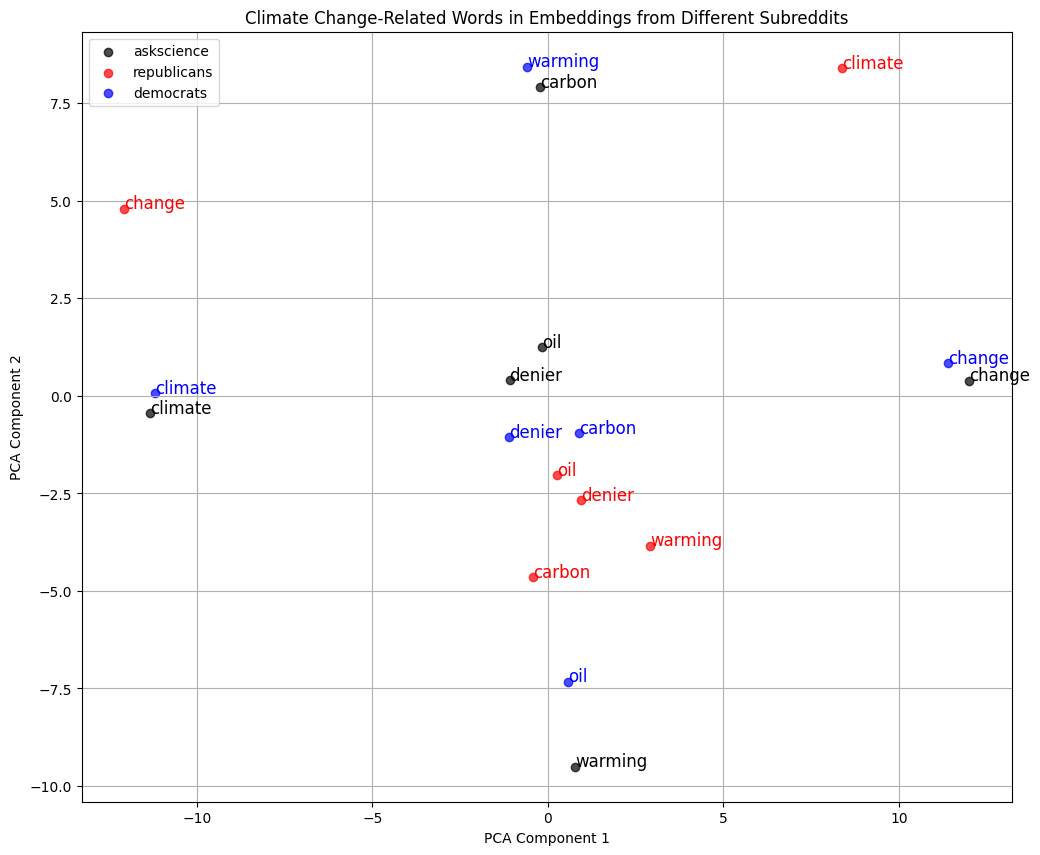

In [315]:
files = ['/Users/fabianmahner/dlss-project24/output/embeddings/subreddit_embeddings/embeddings_CBOW_posts_askscience.csv', 
         '/Users/fabianmahner/dlss-project24/output/embeddings/subreddit_embeddings/embeddings_CBOW_posts_republicans.csv', 
         '/Users/fabianmahner/dlss-project24/output/embeddings/subreddit_embeddings/embeddings_CBOW_posts_democrats.csv'
         ]

embeddings = []

labels = ['askscience', 'republicans', 'democrats'] 
for file in files:
    df = pd.read_csv(file)
    embeddings.append(df)

# Step 2: Filter for climate change-related words
selected_words = ['carbon', 'warming',  'oil', "denier", 'change', 
                   'climate']

# Step 3: Visualize the results
plt.figure(figsize=(12, 10))

colors = ['black', 'red', 'blue']

for i, label in enumerate(labels):
    file_df = embeddings[i]
    file_filtered = file_df[file_df['word'].isin(selected_words)]
    
    if file_filtered.empty:
        continue
    
    # Extract embeddings for the selected words
    word_embeddings = file_filtered.set_index('word').loc[selected_words].values
    
    # Standardize the embeddings
    scaler = StandardScaler()
    word_embeddings_standardized = scaler.fit_transform(word_embeddings)
    
    # Apply PCA separately for each dataset
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(word_embeddings_standardized)
    
    # Plot the PCA results
    plt.scatter(pca_result[:, 0], pca_result[:, 1], color=colors[i], label=label, alpha=0.7)
    
    for j, word in enumerate(selected_words):
        if word in file_filtered['word'].values:
            x = pca_result[j, 0]
            y = pca_result[j, 1]
            plt.text(x, y, word, fontsize=12, color=colors[i])

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Climate Change-Related Words in Embeddings from Different Subreddits')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [302]:
df_filtered

,Unnamed: 0,word,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
9,9,climate,0.630026,0.271395,-0.365355,0.353709,0.065959,-0.307657,-0.095664,-0.021684,...,0.009166,-0.545343,0.300012,0.190454,-0.447839,0.988274,-0.013454,0.232902,0.468823,0.906896
77,77,denier,-0.004606,-0.130641,-0.097392,-0.000711,-0.131052,0.001164,0.196619,0.430872,...,-0.106733,-0.053325,0.047497,0.003558,-0.013442,0.089312,0.088822,-0.147134,0.135570,-0.005351
107,107,carbon,0.436829,0.026624,0.023242,-0.926656,0.414490,0.217861,-0.032791,-0.240026,...,0.157212,0.802752,-0.299862,-0.065438,-0.018344,0.181524,-0.187891,0.206919,0.670367,-0.199560
415,415,oil,0.014416,-0.069643,0.042897,-0.014434,-0.068852,0.061010,-0.104255,-0.046612,...,-0.043237,0.016433,0.077905,-0.016452,0.044748,0.037001,-0.029331,0.040137,0.031804,-0.020442
487,487,warming,-0.148229,-0.097141,0.222538,-0.130880,0.572705,-0.347275,0.413347,-0.340534,...,-0.197011,0.225895,0.400013,0.475893,-0.778773,0.354568,0.656683,0.037400,-0.459557,0.530099
12,12,climate,1.390655,-0.742893,-1.784946,-0.554050,-1.233450,-1.376593,-0.312176,0.129542,...,0.830826,1.080576,0.661620,0.853321,0.554755,0.306476,0.066021,0.866531,1.689991,0.768339
82,82,oil,0.299756,0.864906,0.063842,-0.265611,1.550446,-0.105523,-0.049706,0.341770,...,0.400819,0.709865,0.517776,0.640090,-1.009152,0.438527,-0.724669,-0.702653,-0.828366,-0.367425
98,98,carbon,0.745587,-0.295726,0.827833,-1.397775,0.241879,1.421334,0.021038,-1.127554,...,-0.205278,-0.174960,1.100095,0.386182,-1.308137,-0.661851,-0.588603,1.110342,-1.033911,-0.322391
120,120,warming,-0.111748,-0.764296,-0.249782,-1.580963,1.521180,0.003569,-0.038063,0.270971,...,0.934698,-1.437588,-0.492045,0.480690,-0.959244,-0.001035,-0.168361,-0.468923,-0.516248,0.322104
175,175,denier,0.061224,0.244526,0.249054,0.265721,0.530567,0.231953,-0.480677,-0.039445,...,0.370315,0.986574,1.443582,0.500182,-0.426537,0.102650,-0.007918,-0.212539,0.219368,0.036102


Year 2010: Cosine similarity between 'climate' and 'change': 0.005186113428956234
Year 2011: Cosine similarity between 'climate' and 'change': -0.2576699292579578
Year 2012: Cosine similarity between 'climate' and 'change': 0.6318246873842198
Year 2013: Cosine similarity between 'climate' and 'change': 0.2306091759612672
Year 2014: Cosine similarity between 'climate' and 'change': 0.569899073410055
Year 2015: Cosine similarity between 'climate' and 'change': 0.22755280578537548
Year 2016: Cosine similarity between 'climate' and 'change': 0.20060066933890994
Year 2017: Cosine similarity between 'climate' and 'change': 0.7028387297994022
Year 2018: Cosine similarity between 'climate' and 'change': 0.08877692300776703
Year 2019: Cosine similarity between 'climate' and 'change': 0.7682133271465085
Year 2020: Cosine similarity between 'climate' and 'change': 0.07494098013688347
Year 2021: Cosine similarity between 'climate' and 'change': 0.5865793039271696
Year 2022: Cosine similarity betwe

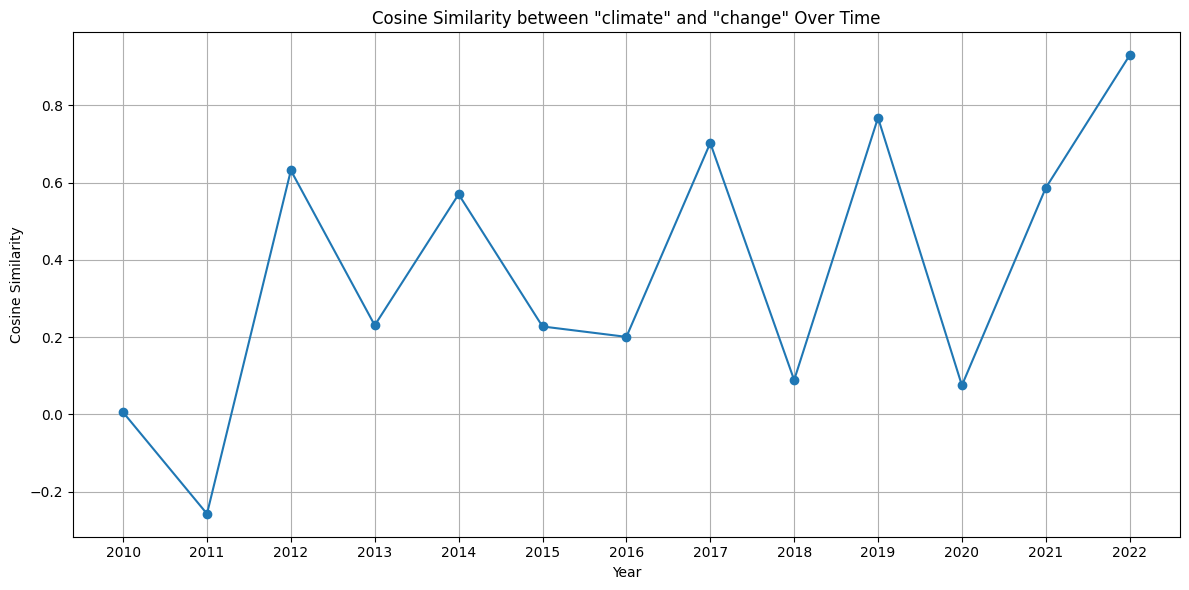


Total change in similarity from 2010 to 2022: 0.9248558988760404


In [266]:
def load_data(file_path):
    """
    Load data from a CSV file and set the index to the 'word' column.

    Parameters:
    file_path (str): The path to the CSV file.

    Returns:
    pandas.DataFrame: The loaded data with the 'word' column set as the index.
    """
    df = pd.read_csv(file_path)
    return df.set_index('word')

def get_word_embedding(df, word):
    """
    Retrieves the word embedding vector for a given word from a DataFrame.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the word embeddings.
    - word (str): The word for which the embedding vector is to be retrieved.

    Returns:
    - numpy.ndarray: The word embedding vector for the given word.
    """
    return df.loc[word].values.reshape(1, -1)

def calculate_cosine_similarity(vec1, vec2):
    """
    Calculates the cosine similarity between two vectors.

    Parameters:
    vec1 (array-like): The first vector.
    vec2 (array-like): The second vector.

    Returns:
    float: The cosine similarity between vec1 and vec2.
    """
    return cosine_similarity(vec1, vec2)[0][0]

# Main process
data_dir = '/Users/fabianmahner/dlss-project24/output/embeddings/yearly_embeddings'  
target_words = ['climate', 'change']
years = []
similarities = []

# Processing  each CSV file
for filename in sorted(os.listdir(data_dir)):
    if filename.endswith('.csv'):
        year = filename.split('_')[-1].split('.')[0]  
        file_path = os.path.join(data_dir, filename)
        
        df = load_data(file_path)
        
        climate_vec = get_word_embedding(df, 'climate')
        change_vec = get_word_embedding(df, 'change')
        
        similarity = calculate_cosine_similarity(climate_vec, change_vec)
        
        years.append(year)
        similarities.append(similarity)
        
        print(f"Year {year}: Cosine similarity between 'climate' and 'change': {similarity}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(years, similarities, marker='o')
plt.xlabel('Year')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between "climate" and "change" Over Time')
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate and print the total change in similarity
total_change = similarities[-1] - similarities[0]
print(f"\nTotal change in similarity from {years[0]} to {years[-1]}: {total_change}")

In [267]:

# Function to find the most similar words to a given word
def find_similar_words(word, word_embeddings, top_n=3):
    """
    Find similar words to a given word based on word embeddings.

    Parameters:
    - word (str): The word to find similar words for.
    - word_embeddings (pandas.DataFrame): The word embeddings matrix.
    - top_n (int): The number of similar words to return (default: 3).

    Returns:
    - similar_words (numpy.ndarray): An array of similar words.
    - similarities (numpy.ndarray): An array of similarity scores corresponding to the similar words.
    """
    word_vector = word_embeddings.loc[word].values.reshape(1, -1)
    similarities = cosine_similarity(word_vector, word_embeddings)
    similarities = similarities.flatten()
    most_similar_indices = np.argsort(similarities)[::-1][1:top_n+1]
    similar_words = word_embeddings.index[most_similar_indices]
    return similar_words, similarities[most_similar_indices]

# List of years from 2010 to 2022
years = list(range(2010, 2022 + 1))

# Dictionary to hold results for each year
results_dict = {}

# Loop through each year and calculate similarities
for year in years:
    # Assuming the embedding files are named as 'embeddings_YEAR.csv'
    file_name = f'/Users/fabianmahner/dlss-project24/output/embeddings/yearly_embeddings/embeddings_CBOW_posts_{year}.csv'
    
    # Load embeddings for the current year
    df_embeddings = pd.read_csv(file_name)
    df_embeddings.set_index('word', inplace=True)
    
    # Calculate cosine similarity between 'climate' and 'change'
    if 'climate' in df_embeddings.index and 'change' in df_embeddings.index:
        climate_vector = df_embeddings.loc['climate'].values.reshape(1, -1)
        change_vector = df_embeddings.loc['change'].values.reshape(1, -1)
        similarity = cosine_similarity(climate_vector, change_vector)[0][0]
    else:
        similarity = np.nan
    
    # Store cosine similarity
    results_dict[year] = {'climate_change_similarity': similarity, 'similar_words': {}}
    
    # Find top 3 similar words for 'climate' and 'change'
    for term in ['climate', 'change']:
        if term in df_embeddings.index:
            similar_words, similarities = find_similar_words(term, df_embeddings, top_n=3)
            results_dict[year]['similar_words'][term] = list(zip(similar_words, similarities))
        else:
            results_dict[year]['similar_words'][term] = [("N/A", 0.0)] * 3  # Handle terms not in the embeddings

# Create a DataFrame to hold the results
all_results = []
for year, data in results_dict.items():
    for term, similar_words in data['similar_words'].items():
        for word, similarity in similar_words:
            all_results.append([year, term, word, f"{similarity:.2f}"])
    all_results.append([year, 'climate_change_similarity', '', f"{data['climate_change_similarity']:.2f}"])

# Convert results to DataFrame
df_results = pd.DataFrame(all_results, columns=['Year', 'Term', 'Similar Word', 'Similarity'])

# Display the table using tabulate for better formatting
print(tabulate(df_results, headers='keys', tablefmt='pipe'))

|    |   Year | Term                      | Similar Word   |   Similarity |
|---:|-------:|:--------------------------|:---------------|-------------:|
|  0 |   2010 | climate                   | warming        |         0.44 |
|  1 |   2010 | climate                   | global         |         0.44 |
|  2 |   2010 | climate                   | lead           |         0.42 |
|  3 |   2010 | change                    | warming        |         0.57 |
|  4 |   2010 | change                    | failure        |         0.56 |
|  5 |   2010 | change                    | it             |         0.54 |
|  6 |   2010 | climate_change_similarity |                |         0.01 |
|  7 |   2011 | climate                   | pollution      |         0.16 |
|  8 |   2011 | climate                   | we             |         0.15 |
|  9 |   2011 | climate                   | global         |         0.15 |
| 10 |   2011 | change                    | warming        |         0.26 |
| 11 |   201

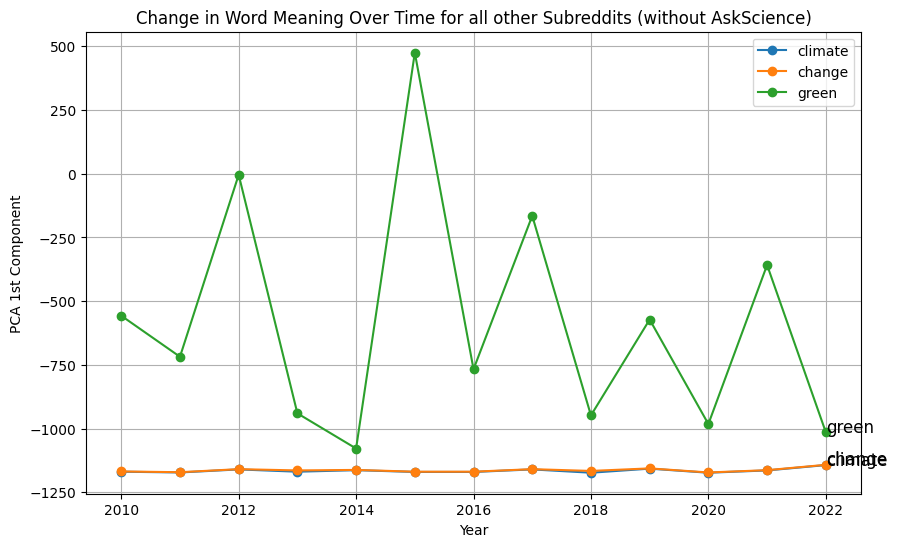

In [268]:
# Step 1: Load the embeddings
years = list(range(2010, 2023))
embeddings = {}
for year in years:
    embeddings[year] = pd.read_csv(f'/Users/fabianmahner/dlss-project24/output/embeddings/not_ask_science_embeddings/embeddings_CBOW_not_ask_science_{year}.csv')

# Step 2: Align the words (ensure all embeddings have the same words)
words = set(embeddings[years[0]]['word'])
for year in years[1:]:
    words &= set(embeddings[year]['word'])

words = list(words)  # list of common words across all years

# Step 3: Concatenate the embeddings for each word across all years
all_embeddings = []

for year in years:
    df = embeddings[year]
    df = df[df['word'].isin(words)]
    all_embeddings.append(df.set_index('word').loc[words].values)

all_embeddings = np.stack(all_embeddings, axis=0)  # Shape: (num_years, num_words, embedding_dim)

# Step 4: Apply PCA to reduce to 1 dimension
# Reshape to (num_years * num_words, embedding_dim) before PCA
all_embeddings_reshaped = all_embeddings.reshape(len(years) * len(words), -1)
pca = PCA(n_components=1)
pca_result = pca.fit_transform(all_embeddings_reshaped)

# Reshape back to (num_years, num_words) after PCA
pca_result = pca_result.reshape(len(years), len(words))

# Step 5: Visualize the change over time for selected words
selected_words = ['climate', 'change', "green"]

plt.figure(figsize=(10, 6))

for word in selected_words:
    index = words.index(word)
    y = pca_result[:, index]  
    plt.plot(years, y, marker='o', label=word)
    plt.text(years[-1], y[-1], word, fontsize=12)

plt.xlabel('Year')
plt.ylabel('PCA 1st Component')
plt.title('Change in Word Meaning Over Time for all other Subreddits (without AskScience)')
plt.legend()
plt.grid(True)
plt.show()

In [269]:
df_embeddings

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
word,,,,,,,,,,,,,,,,,,,,,
city,0,-0.117251,-0.124323,2.034971e-02,0.061574,0.158157,-0.125378,0.105217,0.055704,0.009302,...,0.142152,-0.106667,0.304817,-0.139539,-0.033530,-0.103737,-0.010543,-0.066058,-0.241973,0.076302
without,1,-0.065177,-0.038018,8.027384e-02,0.089384,0.076770,-0.095453,0.113683,0.118476,0.088591,...,-0.029602,0.113699,-0.150923,0.034672,0.033755,0.142123,0.017258,0.057097,0.148046,-0.019377
water,2,-0.216624,-0.005734,1.579692e-01,-0.028478,0.171986,-0.210327,0.232321,0.072448,0.072329,...,-0.035439,0.031099,0.234851,0.066746,-0.229656,-0.206690,0.115994,-0.080266,-0.031953,-0.145862
be,3,-1.232898,-1.419189,-1.558280e+00,1.582984,0.565859,-1.670305,1.586249,-0.033989,-1.376682,...,-0.218761,0.000745,0.002324,0.250861,-0.075122,0.057318,0.024496,0.215019,0.214666,0.514686
our,4,-0.180256,-0.072254,1.679987e-02,0.229266,-0.724992,-0.574015,0.532327,0.349160,0.177924,...,0.263261,0.008156,-0.213375,-0.370201,0.017766,-0.116582,-0.673875,-0.121608,-0.061232,-0.009389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
samsung,7543,0.001035,0.001174,4.172676e-03,-0.000334,-0.005089,-0.000073,0.002926,0.012562,0.004324,...,0.007611,0.006847,0.011945,-0.002553,-0.005271,-0.010070,-0.000493,0.013706,-0.015048,-0.005549
mercosur,7544,0.006129,0.005450,-3.616837e-07,-0.005744,-0.008571,0.000380,0.000379,0.011641,-0.011588,...,0.001346,-0.015180,-0.001131,-0.008579,0.011099,0.002599,0.000001,0.013067,0.000187,0.000003
weeder,7545,-0.006765,0.007428,1.029414e-03,-0.009027,-0.008466,-0.002617,0.000175,0.000901,0.009342,...,-0.013842,0.005480,-0.005586,-0.005392,0.010954,0.020073,0.004542,-0.042721,0.011639,-0.002892


In [270]:
df_dummy = pd.read_csv("/Users/fabianmahner/dlss-project24/output/embeddings/ask_science_embeddings/embeddings_CBOW_ask_science_2012.csv")

In [271]:
df_dummy

,Unnamed: 0,word,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,0,in,-0.082581,0.981079,0.779513,0.125687,0.117239,-0.203982,-0.193097,0.660604,...,0.226067,1.073401,-0.265772,-0.034042,0.932609,-0.004366,0.448156,1.332991,0.272919,-0.101291
1,1,what,0.214144,-0.566363,0.448195,0.027127,0.518443,-1.808941,-1.046210,-1.114625,...,0.498258,1.814345,0.649063,0.938112,-0.256544,-0.098345,0.615537,-0.100552,0.356087,-1.391317
2,2,way,0.537708,0.462166,0.179593,-0.339825,-0.150101,0.610939,-0.306528,0.973524,...,0.202518,0.090010,0.029761,0.822043,-0.026281,0.694176,0.004134,-0.634748,-0.123216,1.226117
3,3,be,-0.393741,-0.426401,0.698833,-0.135871,-0.844273,0.661465,-0.888089,-0.817202,...,0.240165,0.286041,-0.066370,-0.170688,-0.370700,-0.269818,0.527612,-0.014078,0.906092,0.270113
4,4,climate,0.897694,-0.771381,0.127930,-0.627699,1.199164,0.276249,-0.949811,-1.179274,...,-0.747054,-0.348855,-0.688620,0.038353,-0.824268,0.244935,1.397776,1.360991,0.554876,-0.792922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,214,tree,0.072558,-0.423137,0.041408,-0.028773,0.124065,0.236664,-0.094052,0.163881,...,-0.052289,0.066104,0.298616,-0.033974,-0.088039,0.116229,0.294168,-0.280048,0.173283,-0.424880
215,215,!,0.106845,0.026569,0.568086,0.078964,0.063426,0.265819,0.204947,0.275767,...,-0.048663,0.157969,-0.013482,-0.218137,-0.142693,0.034234,-0.931763,0.149980,0.037793,-0.146966
216,216,induce,0.401311,1.072411,-0.377897,0.298135,-1.032860,0.264264,0.506352,0.201245,...,0.611967,-0.567280,0.249237,-0.006477,0.020475,-0.668437,0.164735,-0.630365,0.283006,0.663200
217,217,watch,-0.171630,-0.484068,0.069579,-0.446893,-0.427012,-0.661263,-1.422945,-0.487379,...,-0.026140,0.092675,0.579863,-0.404535,-0.179220,-0.735549,-0.141254,-0.370502,0.210952,-0.177146


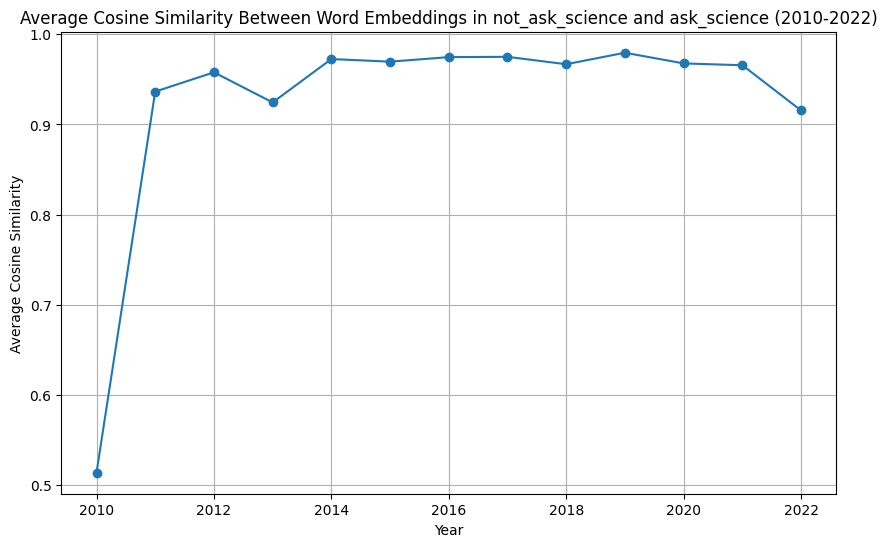

In [274]:
# Define the range of years
years = range(2010, 2023)  # From 2010 to 2022

# Initialize a dictionary to store average similarities across years
similarity_across_years = {}

# Loop through each year and compute similarity
for year in years:
    # Load the embeddings for the current year
    not_ask_science_df = pd.read_csv(f'/Users/fabianmahner/dlss-project24/output/embeddings/not_ask_science_embeddings/embeddings_CBOW_not_ask_science_{year}.csv').set_index('word').sort_index()
    ask_science_df = pd.read_csv(f'/Users/fabianmahner/dlss-project24/output/embeddings/ask_science_embeddings/embeddings_CBOW_ask_science_{year}.csv').set_index('word').sort_index()
    
    # Ensure both DataFrames are aligned on the same words
    common_words = not_ask_science_df.index.intersection(ask_science_df.index)
    not_ask_science_df = not_ask_science_df.loc[common_words]
    ask_science_df = ask_science_df.loc[common_words]
    
    # Compute cosine similarity between corresponding words
    similarity = cosine_similarity(not_ask_science_df, ask_science_df)
    
    # Extract the diagonal (similarity of each word with itself)
    similarity_diag = np.diag(similarity)
    
    # Compute the average similarity for the year
    average_similarity = similarity_diag.mean()
    similarity_across_years[year] = average_similarity

# Convert the results to a DataFrame for easy analysis
similarity_trend_df = pd.DataFrame(list(similarity_across_years.items()), columns=['Year', 'Average Cosine Similarity'])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(similarity_trend_df['Year'], similarity_trend_df['Average Cosine Similarity'], marker='o')
plt.title('Average Cosine Similarity Between Word Embeddings in not_ask_science and ask_science (2010-2022)')
plt.xlabel('Year')
plt.ylabel('Average Cosine Similarity')
plt.grid(True)
plt.show()


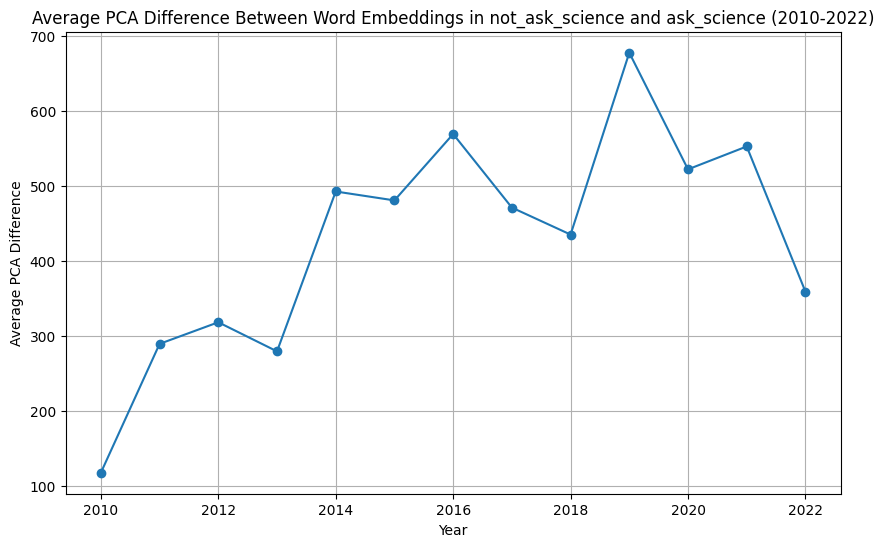

In [275]:
# Define the range of years
years = range(2010, 2023)  # From 2010 to 2022

# Initialize a dictionary to store the average difference in PCA values across years
pca_diff_across_years = {}

# Loop through each year and compute the PCA difference
for year in years:
    # Load the embeddings for the current year
    not_ask_science_df = pd.read_csv(f'/Users/fabianmahner/dlss-project24/output/embeddings/not_ask_science_embeddings/embeddings_CBOW_not_ask_science_{year}.csv').set_index('word').sort_index()
    ask_science_df = pd.read_csv(f'/Users/fabianmahner/dlss-project24/output/embeddings/ask_science_embeddings/embeddings_CBOW_ask_science_{year}.csv').set_index('word').sort_index()
    
    # Ensure both DataFrames are aligned on the same words
    common_words = not_ask_science_df.index.intersection(ask_science_df.index)
    not_ask_science_df = not_ask_science_df.loc[common_words]
    ask_science_df = ask_science_df.loc[common_words]
    
    # Apply PCA to reduce embeddings to 1 dimension
    pca = PCA(n_components=1)
    
    not_ask_science_pca = pca.fit_transform(not_ask_science_df)
    ask_science_pca = pca.fit_transform(ask_science_df)
    
    # Compute the absolute differences between the PCA-reduced values
    pca_diff = np.abs(not_ask_science_pca - ask_science_pca)
    
    # Calculate the average PCA difference for the year
    average_pca_diff = pca_diff.mean()
    pca_diff_across_years[year] = average_pca_diff

# Convert the results to a DataFrame for easy analysis
pca_trend_df = pd.DataFrame(list(pca_diff_across_years.items()), columns=['Year', 'Average PCA Difference'])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(pca_trend_df['Year'], pca_trend_df['Average PCA Difference'], marker='o')
plt.title('Average PCA Difference Between Word Embeddings in not_ask_science and ask_science (2010-2022)')
plt.xlabel('Year')
plt.ylabel('Average PCA Difference')
plt.grid(True)
plt.show()


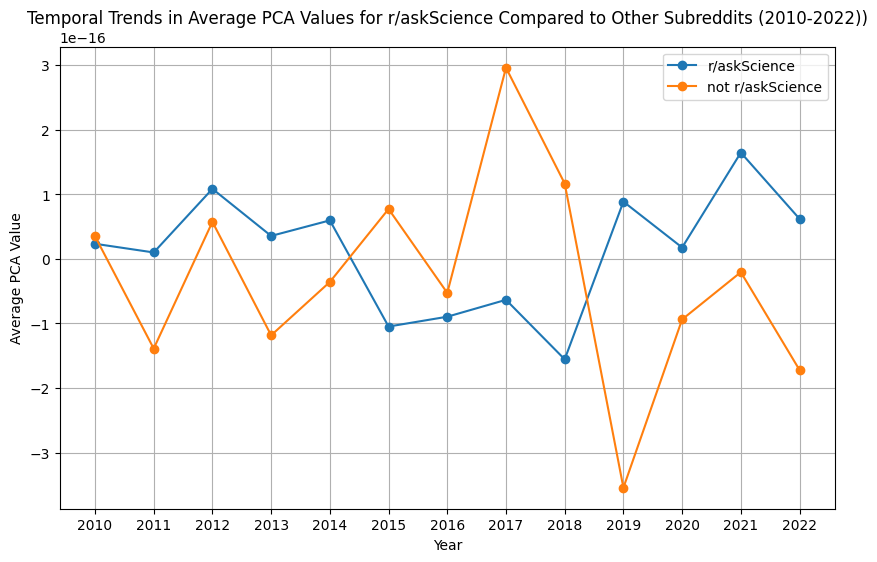

In [321]:
# Define the range of years
years = range(2010, 2023)  # From 2010 to 2022

# Initialize dictionaries to store the average PCA values for each subreddit across years
pca_not_ask_science_across_years = {}
pca_ask_science_across_years = {}

# Loop through each year and compute the PCA for each subreddit
for year in years:
    # Load the embeddings for the current year
    not_ask_science_df = pd.read_csv(f'/Users/fabianmahner/dlss-project24/output/embeddings/not_ask_science_embeddings/embeddings_CBOW_not_ask_science_{year}.csv').set_index('word').sort_index()
    ask_science_df = pd.read_csv(f'/Users/fabianmahner/dlss-project24/output/embeddings/ask_science_embeddings/embeddings_CBOW_ask_science_{year}.csv').set_index('word').sort_index()
    
    
    # Ensure both DataFrames are aligned on the same words
    common_words = not_ask_science_df.index.intersection(ask_science_df.index)
    not_ask_science_df = not_ask_science_df.loc[common_words]
    ask_science_df = ask_science_df.loc[common_words]
    

    scaler = StandardScaler()
    not_ask_science_scaled = scaler.fit_transform(not_ask_science_df)
    ask_science_scaled = scaler.fit_transform(ask_science_df)
    
    # Apply PCA to reduce embeddings to 1 dimension
    pca = PCA(n_components=1)
    
    not_ask_science_pca = pca.fit_transform(not_ask_science_scaled)
    ask_science_pca = pca.fit_transform(ask_science_scaled)
    # Compute the average PCA value for each subreddit
    average_not_ask_science_pca = not_ask_science_pca.mean()
    average_ask_science_pca = ask_science_pca.mean()
    
    # Store the results for each year
    pca_not_ask_science_across_years[year] = average_not_ask_science_pca
    pca_ask_science_across_years[year] = average_ask_science_pca

# Convert the results to DataFrames for easy plotting
pca_not_ask_science_df = pd.DataFrame(list(pca_not_ask_science_across_years.items()), columns=['Year', 'Average PCA Value'])
pca_ask_science_df = pd.DataFrame(list(pca_ask_science_across_years.items()), columns=['Year', 'Average PCA Value'])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(pca_ask_science_df['Year'], pca_ask_science_df['Average PCA Value'], marker='o', label='r/askScience')

plt.plot(pca_not_ask_science_df['Year'], pca_not_ask_science_df['Average PCA Value'], marker='o', label='not r/askScience')
plt.title('Temporal Trends in Average PCA Values for r/askScience Compared to Other Subreddits (2010-2022)')
plt.xlabel('Year')
plt.ylabel('Average PCA Value')
plt.legend()
plt.grid(True)
plt.xticks(pca_ask_science_df['Year'])
plt.show()
